In [1]:
# import the usual libraries
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import cyjax

In [2]:
# random number sequence
rns = cyjax.util.PRNGSequence(42)

# Working with projective coordinates
Projective space $\mathbb{P}^n$ is built from complex space as the quotiont $\mathbb{C}^{n+1}/(\mathbb{C}-\{0\})$.
From this construction we get the homogeneous coordinates

$$
    [z_0:z_1:\ldots:z_n] \;\sim\; [\lambda z_0:\lambda z_1:\ldots:\lambda z_n] \,.
$$

The index $i$ in the homogeneous coordinates $z_i$ will be referred to as a *homogeneous index* here. 
Each naturally defines a patch, in which $z_i \neq 0$.
If we allow $|z| < \infty$, each patch covers all but a null set of points.

Due to the scaling ambiguity, homogeneous coordinates are not coordinates in the stricter sense. Inside each patch $i$, we can obtain affine coordinates by rescaling such that $z_i = 1$ and omitting it:

$$
    [z_0:z_1:\ldots:z_n] \;\sim\; \left[1:\frac{z_1}{z_0}:\ldots:\frac{z_n}{z_0}\right] \;\sim\; (z^{(0)}_0, z^{(0)}_1, \ldots, z^{(0)}_{n-1})
$$


We have two choices of how we can keep track of coordinates:
1. Keep the larger array of homogeneous coordinates but always scale the largest value to 1.
   This allows each coordinate to be represented uniquely by a single array.
   However, we could then not force a function to treat numerical inputs as lying in another patch.
2. Alternatively, we can keep an array of affine coordinates together with an array of patch indices.
   This has the benefit of saving slighly in computational cost, especially where the patch index has to be
   known explicitly, at the cost of carrying around two arrays.
   
When indexing into affine or homogeneous coordinate arrays one has to be somewhat careful, as removing the 'redundant' element with value 1 shifts indices.
The index $k$ with respect to the affine coordinates $z_k^{(i)}$ will here be referred to as *affine* index.
Converting between the *affine* index and *homogeneous* index given an affine patch is simple.
For convenience, appropriate functions are provided.

In [3]:
# if patch > hom_index nothing changes
cyjax.index_hom_to_affine(patch=2, hom_index=1)

Array(1, dtype=int32, weak_type=True)

In [4]:
# if patch < global_index, the local index is reduced by 1;
# note that this function does not check that patch is not equal to global_index!
cyjax.index_hom_to_affine(patch=2, hom_index=3)

Array(2, dtype=int32, weak_type=True)

In [5]:
# the inverse, going from affine index to homogeneous (global) index
cyjax.index_affine_to_hom(patch=2, index=2)

Array(3, dtype=int32, weak_type=True)

## Switching between numerical representations

In [6]:
# Starting with coordinates that are not rescaled yet
zs_hom = jnp.array([1, .5, 2, 0])
zs_hom

Array([1. , 0.5, 2. , 0. ], dtype=float32)

In [7]:
# scale such that all values in unit disk
max_index = jnp.argmax(jnp.abs(zs_hom))
zs_hom = zs_hom / zs_hom[max_index]
zs_hom

Array([0.5 , 0.25, 1.  , 0.  ], dtype=float32)

In [8]:
# convert to affine coordiantes
zs_aff, patch = cyjax.hom_to_affine(zs_hom)
print('patch index', patch)
zs_aff

patch index 2


Array([0.5 , 0.25, 0.  ], dtype=float32)

In [9]:
# switching patches in homogeneous coordinates is simple
print('Hom. in patch index 1')
zs_hom / zs_hom[1]

Hom. in patch index 1


Array([2., 1., 4., 0.], dtype=float32)

In [10]:
# it is slightly more involved for affine coordinates
print('Affine in patch index 1')
cyjax.change_chart(zs_aff, old_patch=patch, new_patch=1)

Affine in patch index 1


Array([2., 4., 0.], dtype=float32)

# Uniformly sampling from projective space
If we sample complex coordinates via uniform distributions in real and imaginary parts, we would not get a uniform distribution in complex angles.

## Uniform components vs angles
If we naively sample real and imaginary parts uniformly, we effectively sample from a square in the complex plane.

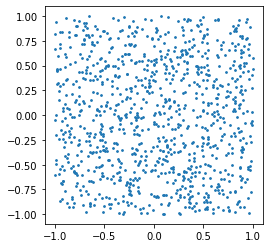

In [11]:
# sample complex numbers with uniformly distributed real/imaginary parts
zs = cyjax.random.uniform_components(next(rns), (1000,))
plt.scatter(zs.flatten().real, zs.flatten().imag, s=3)
plt.gca().set_aspect(1)

We can instead sample complex numbers on the unit disk.

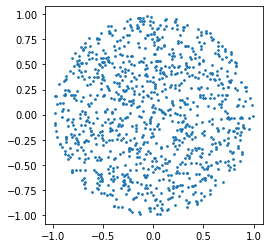

In [12]:
# sample complex numbers with radius 1 and uniform angles
zs = cyjax.random.uniform_angle(next(rns), (1000,))
plt.scatter(zs.real, zs.imag, s=3)
plt.gca().set_aspect(1)

If we interpret these as affine coordinates, we can additionally show where the same points interpreted as affine coordinates of the other patch would lie.

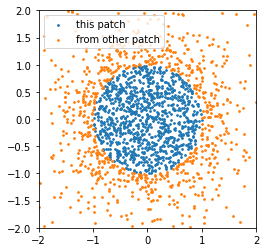

In [13]:
plt.scatter(zs.real, zs.imag, s=3, label='this patch')

# switch affine patch from 0 to 1
zs_other = cyjax.change_chart(zs[:,None], 0, 1).flatten()
plt.scatter(zs_other.real, zs_other.imag, s=3, label='from other patch')
plt.xlim(-2, 2); plt.ylim(-2, 2)  # can get large values from change of chart
plt.legend()
plt.gca().set_aspect(1)

With this method, we can directly sample affine coordinates in the numerically optimal patch where all $|z^k|<1$. However, these are clearly not uniformly distributed in projective space.

Uniform points in projective space can easily be obtain from a uniform sample of the unit sphere.

## Uniform in projective space

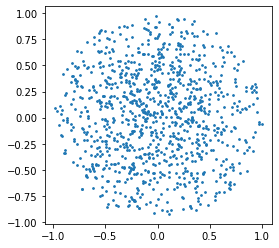

In [14]:
# sample homogeneous coordinates
zs_hom = cyjax.random.complex_sphere(next(rns), (1000, 2))
zs, _ = cyjax.hom_to_affine(zs_hom)  # discard patch index (everything symmetric)

plt.scatter(zs.flatten().real, zs.flatten().imag, s=3)
plt.gca().set_aspect(1)

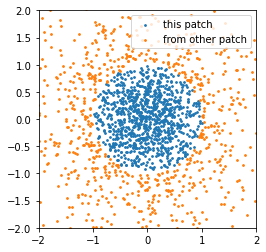

In [15]:
zs_other = cyjax.change_chart(zs[:,None], 0, 1).flatten()
plt.scatter(zs.real, zs.imag, s=3, label='this patch')
plt.scatter(zs_other.real, zs_other.imag, s=3, label='from other patch')
plt.xlim(-2, 2); plt.ylim(-2, 2)  # can get large values from change of chart
plt.legend()
plt.gca().set_aspect(1)